Before one builds a CVAE (Conditional Variational Autoencoder), they should first build a VAE. The VAE should be able to *almost* perfectly reconstruct the input image. This is important to have before you move onto making it conditional on something else (in our case, this would be the crystal structure). This notebook aims to show that a relatively simple VAE setup, with not too many dimensions, can do this.

We have two main parts, and a couple more  important factors to play around with, not including the usual ML ones (optimizer, lr, etc):
- Encoder
- Decoder
- Latent dimensions
- Loss function

We need to encode the input image into two vectors, mean and variance in the latent space (see: Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014). We then reparameterize these two into one vector, which gets passed into the decoder. The decoder simply turns this vector into a new image.



This test uses binary-cross-entropy loss, 20 latent dimensions, and the following conv->deconv setup for the VAE:


```py
self.encoder = nn.Sequential(
    nn.Conv2d(1, 2, kernel_size=3, stride=2, padding=1, bias=False),
    nn.ReLU(),
    nn.Conv2d(2, 4, kernel_size=3, stride=2, padding=1, bias=False),
    nn.ReLU(),
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1, bias=False),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1, bias=False),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 8 * 8, 256),
)

self.fc_mu = nn.Linear(256, latent_dims)
self.fc_var = nn.Linear(256, latent_dims)

self.decoder = nn.Sequential(
    nn.Linear(latent_dims, 16 * 8 * 8),
    nn.ReLU(),
    nn.Unflatten(1, (16, 8, 8)),
    nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.ReLU(),
    nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.ReLU(),
    nn.ConvTranspose2d(4, 2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.ReLU(),
    nn.ConvTranspose2d(2, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Sigmoid(),
)
```

In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sys.path.append(os.path.abspath(os.path.join('..')))
from src.models.components.vae import Model

data_loc = "../data/VAE000/cleaned_data/"

In [3]:
model = Model()
model.load_state_dict(torch.load("saved_models/vae.pt"))
model.eval()

Model(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ResDown(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (2): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel

tensor(0.3412, grad_fn=<AddBackward0>)


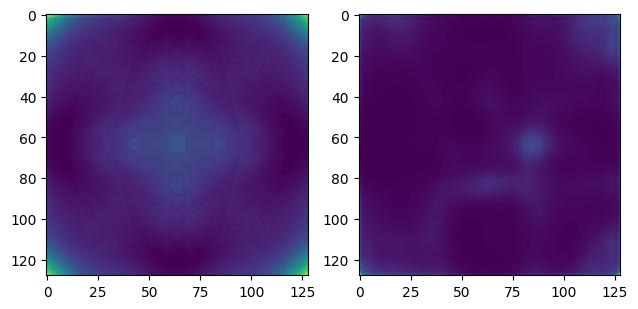

In [52]:
def loss_function(true, predict, mu, logvar):
        x_bar = torch.mean(true)
        y_bar = torch.mean(predict)
        u = true - x_bar
        v = predict - y_bar
        top = torch.dot(u.flatten(), v.flatten())
        bottom = torch.norm(u) * torch.norm(v)
        zncc = top/bottom
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return (1 - zncc) + KLD
CISD_codes = os.listdir(data_loc)

while True:
    CISD_code = np.random.choice(CISD_codes)

    pattern = np.clip(np.fromfile(
        os.path.join(data_loc, CISD_code, CISD_code+"_+0+0+0.bin"),
        dtype=np.float64), 0.0, 1.0)
    pattern_tensor = torch.from_numpy(pattern).to(torch.float32).clone().detach().view(1, 1, 128, 128)

    reconstruction, mu, logvar = model.forward(pattern_tensor)

    loss = loss_function(reconstruction, pattern_tensor, mu, logvar)
    # if loss < 0.01:
    print(loss)
    break

fig, axs = plt.subplots(1, 2)
axs[0].imshow(pattern_tensor.detach().numpy().reshape((128, 128)))
axs[1].imshow(reconstruction.detach().numpy().reshape((128, 128)))

plt.tight_layout()
plt.show()